In [1]:
using Revise

using RigidBodyDynamics
using RigidBodyDynamics: Bounds

using DrakeVisualizer
using Plots
using RigidBodyTreeInspector

using BilevelTrajOpt
gr(size=(500,500), html_output_format=:png);

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9dd84cf97c4fc16956f39829c81f3b6907c8fc83-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9dd84cf97c4fc16956f39829c81f3b6907c8fc83-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [2]:
urdf = joinpath("..", "urdf", "ball.urdf")
mechanism = parse_urdf(Float64, urdf)
body = findbody(mechanism, "ball")
basejoint = joint_to_parent(body, mechanism)
floatingjoint = Joint(basejoint.name, frame_before(basejoint), frame_after(basejoint), QuaternionFloating{Float64}())
replace_joint!(mechanism, basejoint, floatingjoint)
position_bounds(floatingjoint) .= Bounds(-100, 100)
velocity_bounds(floatingjoint) .= Bounds(-100, 100)
env = parse_contacts(mechanism, urdf, .5);
x0 = MechanismState(mechanism)
Δt = 0.01;

In [24]:
q0 = [1., 0., 0., 0., 0., 0., .025]
v0 = [0., 0., 0., .25, 0. , 0.]
N = 10

set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)

println("Explicit Contacts")
traj_exp = BilevelTrajOpt.simulate(x0,env,Δt,N,implicit_contact=false);
println("Implicit Contacts")
traj_imp = BilevelTrajOpt.simulate(x0,env,Δt,N,implicit_contact=true);

Explicit Contacts
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Implicit Contacts
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solved_To_Acceptable_Level
Solve_Succeeded
Solved_To_Acceptable_Level
Solve_Succeeded


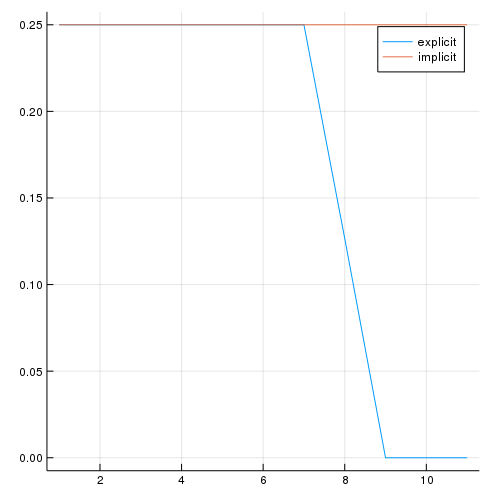

In [39]:
ts = cumsum([Δt for i in 1:N]);
plot(traj_exp[11,:],label="explicit")
plot!(traj_imp[11,:],label="implicit")

In [56]:
# println(traj_exp[7+6+1:end,9])
println(traj_imp[7+6+1:end,9])

[0.0, 0.366802, 0.672334, 0.3668, 0.671554, 0.253828, 5.49821]


In [58]:
println(traj_imp[1:13,9])

[1.0, 1.8722e-14, -2.33457e-10, 1.01223e-16, 0.0199995, 1.78903e-6, -9.99477e-9, 9.35363e-17, -1.16731e-12, 3.62294e-22, 0.249991, 9.77758e-5, 3.62716e-5]


In [60]:
println(traj_imp[14:end,9])

[0.0, 0.366802, 0.672334, 0.3668, 0.671554, 0.253828, 5.49821]


In [26]:
DrakeVisualizer.any_open_windows() || (DrakeVisualizer.new_window(); sleep(1));
geometries = visual_elements(mechanism, URDFVisuals(urdf))
vis = Visualizer(mechanism, geometries);

In [36]:
traj = traj_exp
qs = [traj[1:num_positions(x0),i] for i in 1:N]
ts = cumsum([Δt for i in 1:N]);
RigidBodyTreeInspector.animate(vis, mechanism, ts, qs; realtimerate = .25);